# Quantum Credit Risk Analysis

*Authors: Arjun Puppala, Jose Ramon Aleman, Marti Ciurana*

*Tutor: Giulio Gasbarri*

## **Abstract**

*We introduce and describe an iterative algorithm of the Quantum Amplitude Estimation (QAE), known as the Iterative QAE (IQAE). This is used for estimating credit risk that outperforms Monte Carlo (MC) simulations on traditional computers. We calculate the Economic Capital (EC) required, which is the difference between the Value at Risk (VaR) and the predicted Loss Distribution Value (LDV). The calculation of the EC required is of interest, because it quantifies the amount of capital required to be solvent at a certain level of confidence, making it an important risk statistic. We implement this problem for a realistic LDV and analyze its scaling to a realistic problem size. We present estimates of the overall number of necessary qubits, the expected circuit depth, and how this translates into an expected runtime on future fault-tolerant quantum hardware under acceptable assumptions.*


## 1. Introduction

The credit risk analysis is a form of analysis performed (normally by a credit analyst) to determine a borrower’s ability to meet their debt obligations. The purpose of credit risk analysis is to determine the creditworthiness of borrowers by quantifying the risk of loss that the lender is exposed to. The three factors that lenders use to quantify credit risk include: the probability of default, the loss given of default, and exposure of default. [[1]](https://corporatefinanceinstitute.com/resources/knowledge/credit/purpose-of-credit-risk-analysis/)

The usage of quantum computers could allow faster and more accurate solutions, for example, to determinate the credit risk profile of a client. It is said that financial institutions that can make the most of quantum computing are likely to see significant benefits. Banks and asset managers optimize portfolios based on computationally intense models that process large sets of variables, and for this reason, they will be able to more effectively analyze large or unstructured data sets.

In valuation, for example, the ability to speedily identify an optimal risk-adjusted portfolio is likely to create significant competitive advantage. For loan and bond portfolios, more precise estimates of credit exposures should lead to better optimization decisions.

American and European banks are also exploring quantum computing opportunities. [[2]](https://www.mckinsey.com/industries/financial-services/our-insights/how-quantum-computing-could-change-financial-services)

- Bank of America strategist said quantum computing would be: "as revolutionary in the 2020s as smartphones were in the 2010s".
- BBVA has formed a partnership to explore portfolio optimization and more efficient Monte Carlo modelling.
- Caixa Bank is running a trial hybrid framework of quantum and conventional computing with the aim of better classifying credit risk profiles.

## 2. Problem Description

We can describe the problem as the simple default risk, that a lender takes on in the chance that a borrower will be unable to make the required payments on their debt obligation. Whenever a lender extends credit to a borrower, there is a chance that the loan amount will not be paid back. The measurement that looks at this probability is the default risk. 

The default risk applies to both individuals who borrow money, and companies that issue bonds and due to financial constraints, are not able to make interest payments on those bonds. Whenever a lender extends credit, calculating the default risk of a borrower is crucial as part of its risk management strategy. Whenever an investor is evaluating an investment, determining the financial health of a company or private person is crucial in gauging investment risk.

Lenders generally examine a company's financial statements and employ several financial ratios to determine the likelihood of debt repayment. Free cash flow is the cash that is generated after the company reinvests in itself and is calculated by subtracting capital expenditures from operating cash flow. Free cash flow is used for things such as debt and dividend payments. A free cash flow figure that is near zero or negative indicates that the company may be having trouble generating the cash necessary to deliver on promised payments. This could indicate a higher default risk. The default risk on a debt arises from a borrower failing to make the required payments, for example:

- A consumer may fail to make a payment due on a mortgage loan, credit card, line of credit, or other loan.
- A company is unable to repay asset-secured fixed or floating charge debt.
- A business or consumer does not pay a trade invoice when due.

### 2.1. Problem Definition

We analyze the credit risk of a portfolio of $k$ assets. The default probability of every asset $k$ follows a Gaussian Conditional Independence model, i.e., given a value $z$ sampled from a latent random variable $Z$ following a standard normal distribution, the default probability of asset $k$ is given by:

$$ p_k(z) = F\left( \frac{F^{-1}(p_k^0) - \sqrt{\rho_k}z}{\sqrt{1 - \rho_k}} \right) $$
 
where $F$ denotes the cumulative distribution function of $Z$, $p_k^0$ is the default probability of asset $k$ for $z=0$ and $\rho_k$ is the sensitivity of the default probability of asset $k$ with respect to $Z$. Thus, given a concrete realization of $Z$ the individual default events are assumed to be independent from each other.

We are interested in analyzing risk measures of the total loss

$$ L = \sum_{k=1}^K \lambda_k X_k(Z) $$

where $\lambda_k$ denotes the loss given default of asset $k$, and given $Z$, $X_k(Z)$ denotes a Bernoulli variable representing the default event of asset $k$. More precisely, we are interested in the expected value $\mathbb{E}[L]$, the Value at Risk (VaR) of $L$ and the Conditional Value at Risk (CVaR) of $L$ (also called Expected Shortfall).

Where VaR is defined as:

$$ \text{VaR}_{\alpha}(L) = \inf \{ x \mid \mathbb{P}[L <= x] \geq 1 - \alpha \} $$

and CVaR with confidence level $\alpha \in [0, 1]$, is defined:

$$ \text{CVaR}_{\alpha}(L) = \mathbb{E}[ L \mid L \geq \text{VaR}_{\alpha}(L)] $$


### 2.2. Problem Parameters

The introduced quantum algorithm for estimating the credit at risk, Iterative Quantum Amplitude Estimation (IQAE), does not rely on Quantum Phase Estimation (QPE), and is based on Grover’s Algorithm, reducing the required number of qubits and gates needed. We provide a rigorous analysis of IQAE and prove that it achieves a quadratic speedup up to a double-logarithmic factor compared to classical Monte Carlo simulation. We test the algorithm in a two (2) assets portfolio.

In [1]:
### Python Dependencies (used for simulations and graphs)
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, QuantumCircuit, Aer, execute
from qiskit.circuit.library import IntegerComparator, WeightedAdder, LinearAmplitudeFunction
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI


The problem parameters are defined by the following:

1. Number of qubits used to represent $Z$, denoted by $n_z$
2. Truncation value for $Z$, denoted by $z_\text{max}$, i.e., $Z$ is assumed to take $2^{n_z}$ equidistant values in $\{-z_\text{max},...,+z_\text{max}\}$
3. Base default probabilities for each asset $p_0^k \in (0,1)$, $k=1, ..., K$  
4. Sensitivities of the default probabilities with respect to $Z$, denoted by $\rho_k \in [0,1)$ 
5. Loss given default for asset $k$, denoted by $\lambda_k$
6. Confidence level for VaR / CVaR $\alpha \in [0,1]$.

In [2]:
# Number of qubits used to represent $Z$, denoted by $n_z$
n_z = 2
z_max = 2
# Truncation value for $Z$, denoted by $z_\text{max}$, i.e., $Z$ is assumed to take $2^{n_z}$ equidistant values in $\{-z_\text{max},...,+z_\text{max}\}$
z_values = np.linspace(-z_max, z_max, 2 ** n_z)
# Base default probabilities for each asset
p_zeros = [0.15, 0.25]
# Sensitivities of the default probabilities with respect to $Z$
rhos = [0.1, 0.05]
# Loss given default for asset
lgd = [1, 2]
# Confidence level for VaR / CVaR 
K = len(p_zeros)
alpha = 0.05

# Grover Algorithm Data
grover = int(12)
data = range(grover)
prob = np.ones(grover)
winner = ['','','','','','','|w⟩','','','','','']
avg_amplitude = ['', '1/√N', '']

# Graph styles
label_size = 12
title_size = 16
c_off = 'lightgray'
c_on = 'black'
c = [c_off, c_off, c_off, c_off, c_off, c_off, c_on, c_off, c_off, c_off, c_off]


## 3. Methods

In order to further demonstrate the capabilities of IQAE, we used classical simulations of quantum hardware to show that it can also be applied to speed up the computation of risk measures of a simple two-asset (2) portfolio. Nevertheless, we notice that to achieve quantum advantage in a real-world scenario, the quality of current quantum hardware needs to be improved. Errors arising from the limited coherence time and cross-talk when measuring the states of qubits need to be substantially suppressed. Furthermore, because of this reason, the number of qubits must be increased.

We went on to show how IQAE can be applied to the task of pricing an asset using real quantum hardware. However, the current pace of advances in research directed at improving both quantum hardware and quantum algorithms makes us optimistic that real quantum advantage in risk analysis can be achieved in the future.

### 3.1. Estimate the Risk

Value at risk (VaR) is a statistic that quantifies the extent of possible financial losses within a firm, portfolio, or position over a specific time frame. The CVar quantifies the average expected loss. A financial firm, for example, may determine an asset has a 3% one-month VaR of 2%, representing a 3% chance of the asset declining in value by 2% during the one-month time frame. The conversion of the 3% chance of occurrence to a daily ratio places the odds of a 2% loss at one day per month.

### 3.2. Classical Method: Monte Carlo (MC)

The Monte Carlo (MC) method is a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. The underlying concept is to use randomness to solve problems that might be deterministic in principle. MC predicts a set of outcomes based on an estimated range of values versus a set of fixed input values. 

In other words, a MC simulation builds a model of possible results by leveraging a probability distribution, such as a uniform or normal distribution, for any variable that has inherent uncertainty. It recalculates the results over and over, each time using a different set of random numbers between the minimum and maximum values. In a typical MC experiment, this exercise can be repeated thousands of times to produce a large number of likely outcomes.

The idea behind MC integration is to estimate the area under a (high dimensional) surface by taking random points and counting how many fall. The error goes down like the reciprocal of the square root of the number of points. The error estimate has nothing to do with the dimension, in that sense, MC integration is indeed independent of dimension, and for that reason is often used for numerical integration in dimensions too high to use product methods.

When this is translated into software, those n dimensions are the equivalent of a software with n features. If there are no points in the region of interest, we would estimate the volume of the region of interest to be zero. The volume is very small, and the absolute error in estimating a small number to be zero is small, but the relative is 100%. Several combinations of different scenarios are tested and the result of each scenario is analyzed, and for this reason, it’s slow and expensive.

### 3.3. Quantum Amplitude Estimation (QAE)

QAE is one of the algorithms at the basis of the quantum revolution, it can be understood as a combination of Quantum Phase Estimation (QPE) and Grover Algorithm. It is useful to estimate the VaR, and has the potential to achieve a quadratic speed up for most of the application that are nowadays solved through Monte Carlo (MC) simulations, while these simulations scale with $𝒪(1/\sqrt{M})$ with $M$ the number of samples, QAE achieve a scaling of $𝒪(1/M)$, where $M$ are the quantum samples. It has been shown that we can leverage QAE in the financial service sector, e.g., for risk analysis, option pricing, and also for generic tasks such as numerical integration. However, we do not provide rigorous proofs of the correctness of the proposed algorithms. It is not even clear how to control the accuracy of the algorithm other than possibly increasing the number of measurements of the evolving quantum circuits.

In the following, we propose an alternative version of QAE, the Iterative QAE (IQAE). It achieves better results than previous tested algorithms. It requires iterative queries to the quantum computer to achieve the quadratic speedup and cannot be parallelized. Although parallelization is a nice feature, the potential speedup is limited. Assuming the length of the queries is doubled in each iteration, the speedup is at most a factor of two since the computationally most expensive query dominates all the others. Has the desired asymptotic behavior up to a multiplicative $\log{(2/\alpha \log{2(\pi/ 4 \epsilon)})}$ factor, where $ϵ > 0$ denotes the target accuracy, and $1 − α$ the resulting confidence level. [[8]](https://www.nature.com/articles/s41534-021-00379-1)

Before showing the results of applying the IQAE algorithm, we will discuss the mapping of the problem in the quantum operator $A$, discuss about the operator $Q$, how to map the uncertainty model in a quantum register, and how the problem of the expected loss is mapped in a quantum circuit. This improves the results without additional queries to the quantum computer and allows us to derive proper confidence intervals.

#### 3.3.1 Grover's Algorithm

In this section, we introduce Grover's algorithm and how it can be used to solve unstructured search problems. This algorithm can speed up an unstructured search problem quadratically.

Suppose you are given a large list of $N$ items. Among these items there is one item with a unique property that we wish to locate; we will call this one the winner $w$. To find the marked item using classical computation, one would have to check on average ${N\over2}$ of these boxes, and in the worst case, all $N$ of them. On a quantum computer, however, we can find the marked item in roughly $√N$ steps with Grover's algorithm.

Before looking at the list of items, we have no idea where the marked item is. Therefore, any guess of its location is as good as any other, which can be expressed in terms of a uniform superposition:

$$|s \rangle = \frac{1}{\sqrt{N}} \sum_{x = 0}^{N -1} | x \rangle.$$

If at this point we were to measure in the standard basis $\{|x⟩\}$, this superposition would collapse, according to the fifth quantum law, to any one of the basis states with the same probability of ${1\over{n}} = {1\over{2^n}}$. Our chances of guessing the right value $w$ is therefore $1$ in $2^n$, as could be expected. Hence, on average we would need to try about ${N\over{2}} = 2^{n-1}$ times to guess the correct item.

This algorithm has a nice geometrical interpretation in terms of two reflections, which generate a rotation in a two-dimensional plane. The only two special states we need to consider are the winner $|w⟩$ and the uniform superposition $|s⟩$. These two vectors span a two-dimensional plane in the vector space $\mathbb{C}^n$.

They are not quite perpendicular because $|w⟩$ occurs in the superposition with amplitude $N^{-1/2}$ as well. We can, however, introduce an additional state $|s′⟩$ that is in the span of these two vectors, which is perpendicular to $|w⟩$ and is obtained from $|s⟩$ by removing $|w⟩$ and rescaling.

##### 3.3.1.1. Amplitude Amplification

The amplitude amplification procedure [[6]](http://arxiv.org/abs/quant-ph/0005055) starts out in the uniform superposition $|s⟩$, which is easily constructed from:

$$ |s\rangle = H^{\otimes n} | 0 \rangle^n $$

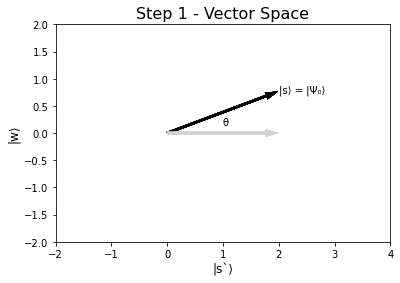

In [3]:
# Vector origin location
X = [0]
Y = [0]

# Directional vectors
U = [2]
V = [0.75]

# Draw graph
plt.title("Step 1 - Vector Space", size=title_size)
plt.ylabel("|w⟩", size=label_size)
plt.xlabel("|s`⟩", size=label_size)
plt.quiver(X, Y, U, V, color=c_on, units='xy', scale=prob)
plt.quiver(X, Y, [2], [0], color=c_off, units='xy', scale=prob)
plt.text(1, 0.15, 'θ')
plt.text(2, 0.75, '|s⟩ = |Ψ₀⟩')
plt.xlim(-2, 4)
plt.ylim(-2, 2)
plt.show()

Corresponds to the two-dimensional plane spanned by perpendicular vectors $|w⟩$ and $|s′⟩$ which allows to express the initial state as: 

$$ |s\rangle = \sin \theta | w \rangle + \cos \theta | s' \rangle $$

Where

$$ \theta = \arcsin \langle s | w \rangle = \arcsin \frac{1}{\sqrt{N}} $$

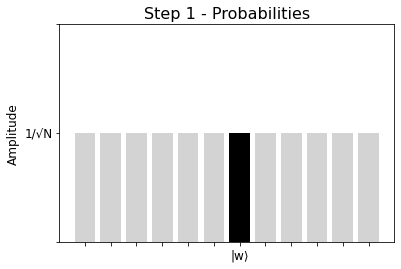

In [4]:
# Draw graph
plt.title("Step 1 - Probabilities", size=title_size)
plt.ylabel("Amplitude", size=label_size)
plt.bar(data, prob, color=c)
plt.xticks(data, winner, size=label_size)
plt.yticks(range(3), avg_amplitude, size=label_size)
plt.show()

Graph of the amplitudes of the state $|s⟩$.

##### 3.3.1.2. Oracle and Phase Inversion

We apply the oracle reflection $U_f$ to the state $|s⟩$:

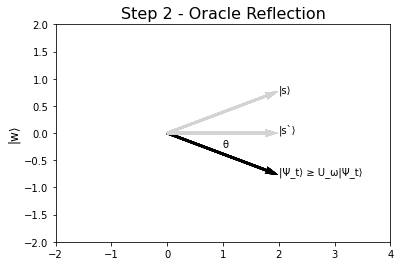

In [5]:
# Vector origin location
X = [0]
Y = [0]

# Directional vectors
U = [2]
V = [-0.75]

# Draw graph
plt.title("Step 2 - Oracle Reflection", size=title_size)
plt.ylabel("|w⟩", size=label_size)
plt.quiver(X, Y, U, V, color=c_on, units='xy', scale=prob)
plt.quiver(X, Y, [2], [0], color=c_off, units='xy', scale=prob)
plt.quiver(X, Y, [2], [V[0] * -1], color=c_off, units='xy', scale=prob)
plt.text(1, -0.25, 'θ')
plt.text(2, 0, '|s`⟩')
plt.text(2, V[0] * -1, '|s⟩')
plt.text(2, V[0], '|Ψ_t⟩ ≥ U_ω|Ψ_t⟩')
plt.xlim(-2, 4)
plt.ylim(-2, 2)
plt.show()

Geometrically this corresponds to a reflection of the state $|s⟩$ about $|s′⟩$.

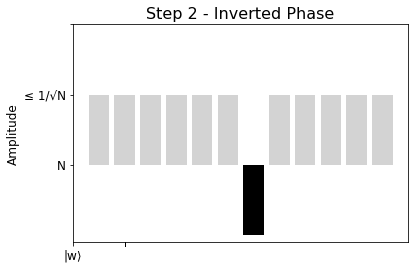

In [6]:
# Function to flag set by inverting its value
def invert_phase(l1, p):
    inverted = []
    for i in range(len(l1)):
        val = p if l1[i] == '' else -1 * p
        inverted.insert(i, val)
    return inverted

# Draw graph
new_amplitude = ['N', '≤ {}'.format(avg_amplitude[1]), '']
plt.title("Step 2 - Inverted Phase", size=title_size)
plt.ylabel("Amplitude", size=label_size)
plt.bar(data, invert_phase(winner, 1), color=c)
plt.xticks(invert_phase(winner, 1), winner, size=label_size)
plt.yticks(range(3), new_amplitude, size=label_size)
plt.show()

This transformation means that the amplitude in front of the $|w⟩$ state becomes negative, which in turn means that the average amplitude (indicated by a dashed line) has been lowered.

##### 3.3.1.3. Reflection and Rotation

We now apply an additional reflection $(U_s)$  about the state

$$ |s\rangle:U_s = 2|s\rangle\langle s| - \mathbb{1} $$

This transformation maps the state to $ U_s U_f| s \rangle $ and completes the transformation.

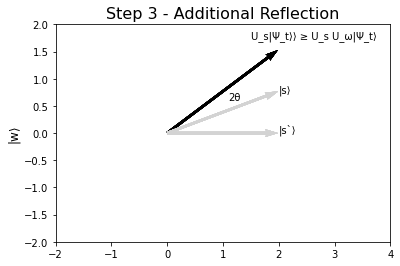

In [7]:
# Vector origin location
X = [0]
Y = [0]

# Directional vectors
U = [2]  
V = [1.5]

# Draw graph
plt.title("Step 3 - Additional Reflection", size=title_size)
plt.ylabel("|w⟩", size=label_size)
plt.quiver(X, Y, U, V, color=c_on, units='xy', scale=prob)
plt.quiver(X, Y, U, [0], color=c_off, units='xy', scale=prob)
plt.quiver(X, Y, U, [0.75], color=c_off, units='xy', scale=prob)
plt.text(1.1, 0.6, '2θ')
plt.text(2, 0, '|s`⟩')
plt.text(2, 0.75, '|s⟩')
plt.text(1.5, 1.75, 'U_s|Ψ_t⟩⟩ ≥ U_s U_ω|Ψ_t⟩')
plt.xlim(-2, 4)
plt.ylim(-2, 2)
plt.show()

Two reflections always correspond to a rotation. 

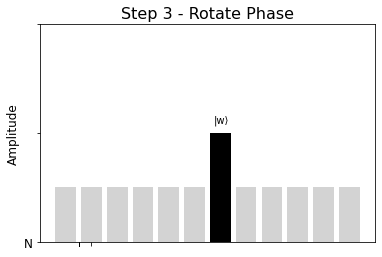

In [8]:
# Function to amplify winner item
def amplify_winner(l1):
    amplified = []
    for i in range(len(l1)):
        val = 0.5 if l1[i] == '' else 1
        amplified.insert(i, val)
    return amplified

# Draw graph
new_amplitude = ['N', '', '']
plt.title("Step 3 - Rotate Phase", size=title_size)
plt.ylabel("Amplitude", size=label_size)
plt.bar(data, amplify_winner(winner), color=c)
plt.xticks(amplify_winner(winner), ["" for x in range(grover)])
plt.yticks(range(3), new_amplitude, size=label_size)
plt.text(5.75, 1.1, '|w⟩')
plt.show()

The transformation $U_sU_f$ rotates the initial state $|s⟩$ closer towards the winner $|w⟩$.

The action of the reflection $U_s$ in the amplitude bar diagram can be understood as a reflection about the average amplitude. Since the average amplitude has been lowered by the first reflection, this transformation boosts the negative amplitude of $|w⟩$ to roughly three (3) times its original value, while it decreases the other amplitudes. We then go to step 2 (oracle and phase inversion) to repeat the application. This procedure will be repeated several times to zero in on the winner.

After $t$ steps we will be in the state $|ψ_t⟩$ where:

$$ | \psi_t \rangle = (U_s U_f)^t  | s \rangle $$

![grover-hl](assets/diagrams/grover-circuit-high-level.png)


#### 3.3.1.4. Grover's Algorithm Search Implementation

The three stages of the 3-qubit Grover search algorithm: initialization, oracle, and amplification. [[7]](https://scx2.b-cdn.net/gfx/news/2018/groversearch.jpg)

![grover-search](assets/diagrams/grover-search.jpeg)

#### 3.3.2. Quantum Fourier Transform

The Fourier Transform occurs in many different versions throughout classical computing, in areas ranging from signal processing to data compression to complexity theory. The Quantum Fourier Transform (QFT) is the quantum equivalent implementation of the discrete Fourier Transform over the amplitudes of a wavefunction.

The discrete Fourier transform acts on a vector $(x0,...,x_{N−1})$ and maps it to the vector $(y0,...,y_{N−1})$ according to the formula:

$$ y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk} $$

where: $ \omega_N^{jk} = e^{2\pi i \frac{jk}{N}} $

Similarly, QFT acts on a quantum state $ \vert X\rangle = \sum_{j=0}^{N-1} x_j \vert j \rangle $ and maps it to the quantum state $ \vert Y\rangle = \sum_{k=0}^{N-1} y_k \vert k \rangle $ according to the formula:

$$ y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk} $$

We see that only the amplitudes of the state were affected by this transformation. This can also be expressed as the unitary matrix:

$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1} \omega_N^{jk} \vert k \rangle \langle j \vert $$

The QFT transforms between two bases, the computational (Z) basis, and the Fourier basis. The H-gate is the single-qubit QFT, and it transforms between the Z-basis states $|0⟩$ and $|1⟩$ to the X-basis states $|+⟩$ and $|−⟩$. In the same way, all multi-qubit states in the computational basis have corresponding states in the Fourier basis. The QFT is simply the function that transforms between these bases.

$$ |\text{State in Computational Basis}\rangle \quad \xrightarrow[]{\text{QFT}} \quad |\text{State in Fourier Basis}\rangle $$

(We differentiate states in the Fourier basis using tilde (~)).

##### 3.3.2.1. Counting in the Fourier basis:

In the computational basis, we store numbers in binary using the states $|0⟩$ and $|1⟩$:

![z-basis](assets/plot/zbasis-counting.gif)

The frequency with which the different qubits change; the leftmost qubit flips with every increment in the number, the next with every 2 increments, the third with every 4 increments, and so on. In the Fourier basis, we store numbers using different rotations around the Z-axis:

![fourier-basis](assets/plot/fourierbasis-counting.gif)

The number we want to store dictates the angle at which each qubit is rotated around the Z-axis. In the state $|\widetilde{0}\rangle$, all qubits are in the state $|\widetilde{+}\rangle$. As seen in the example above, to encode the state $|\widetilde{5}\rangle$ on 4 qubits, we rotated the leftmost qubit by $\tfrac{5}{2^n} = \tfrac{5}{16}$ full turns ($\tfrac{5}{16}\times 2\pi$ radians). The next qubit is turned double this radians, $\tfrac{10}{16}\times 2\pi$, this angle is then doubled for the qubit after, and so on. Note the frequency of each changing qubit, the leftmost qubit (qubit 0) in this case has the lowest frequency, and the rightmost the highest.

## 4. Results

In this section, we show our results, including the value at risk obtained and corresponding probability, conditional value at risk, expected loss, the plot of probability distribution of the two assets, the results of the simulation with noise, the difference between the simulation with and without noise and comparing it with the MC simulation.

### 4.1. Uncertainty Model

We now construct a circuit that loads the uncertainty model. This can be achieved by creating a quantum state in a register of $n_z$ qubits that represents $Z$ following a standard normal distribution. This state is then used to control single qubit Y-rotations on a second qubit register of $K$ qubits, where a $|1\rangle$ state of qubit $k$ represents the default event of asset $k$. [[3]](https://qiskit.org/documentation/finance/tutorials/09_credit_risk_analysis.html)

The resulting quantum state can be written as:

$ |\Psi\rangle = \sum_{i=0}^{2^{n_z}-1} \sqrt{p_z^i} |z_i \rangle \bigotimes_{k=1}^K
\left( \sqrt{1 - p_k(z_i)}|0\rangle + \sqrt{p_k(z_i)}|1\rangle\right) $

Where we denote by $z_i$ the $i$-th value of the discretized and truncated $Z$. [[5]](https://arxiv.org/abs/1907.03044)

In [9]:
u = GCI(n_z, z_max, p_zeros, rhos)
u.draw()

┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │  P(X) │
q_2: ┤2      ├
     │       │
q_3: ┤3      ├
     └───────┘

We now use the simulator to validate the circuit that constructs $|\Psi\rangle$ and compute the corresponding exact values for: 

- Expected loss $\mathbb{E}(L)$ 
- Value at Risk $VaR(L)$ and corresponding probability
- Conditional Value at Risk $CVaR(L)$ 

In [10]:
# Execute circuit and analyze results
exe = execute(u, backend=Aer.get_backend("statevector_simulator"))

# Initialize variables
p_z = np.zeros(2 ** n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = u.num_qubits

# Analyze uncertainty circuit and determine exact solutions
state = exe.result().get_statevector()
if not isinstance(state, np.ndarray):
    state = state.data

for i, a in enumerate(state):
    # Get binary representation
    b = ("{0:0%sb}" % num_qubits).format(i)
    prob = np.abs(a) ** 2
    # Extract value of Z and corresponding probability
    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob
    # Determine overall default probability for k
    loss = 0
    for k in range(K):
        if b[K - k - 1] == "1":
            p_default[k] += prob
            loss += lgd[k]
    values += [loss]
    probabilities += [prob]

# Calculate results
values = np.array(values)
probabilities = np.array(probabilities)
losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
expected_loss = np.dot(values, probabilities)
cdf = np.cumsum(pdf)
i_var = np.argmax(cdf >= 1 - alpha)
exact_var = losses[i_var]
exact_cvar = np.dot(pdf[(i_var + 1) :], losses[(i_var + 1) :]) / sum(pdf[(i_var + 1) :])

# Print results
print("P[L] <= VaR[L]]:                   %.4f" % cdf[exact_var])
print("Expected Loss E[L]:                %.4f" % expected_loss)
print("Value at Risk VaR[L]:              %.4f" % exact_var)
print("Conditional Value at Risk CVaR[L]: %.4f" % exact_cvar)

P[L] <= VaR[L]]:                   0.9591
Expected Loss E[L]:                0.6409
Value at Risk VaR[L]:              2.0000
Conditional Value at Risk CVaR[L]: 3.0000


##### 4.1.1. Loss Distribution

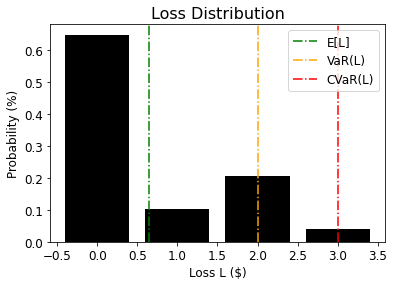

In [11]:
# Plot loss PDF, expected loss, var, and cvar
plt.bar(losses, pdf, color=c_on)
plt.axvline(expected_loss, color="green", linestyle="dashdot", label="E[L]")
plt.axvline(exact_var, color="orange", linestyle="dashdot", label="VaR(L)")
plt.axvline(exact_cvar, color="red", linestyle="dashdot", label="CVaR(L)")
plt.legend(fontsize=label_size)
plt.xlabel("Loss L ($)", size=label_size)
plt.ylabel("Probability (%)", size=label_size)
plt.title("Loss Distribution", size=title_size)
plt.xticks(size=label_size)
plt.yticks(size=label_size)
plt.show()

##### 4.1.2. Z Distribution


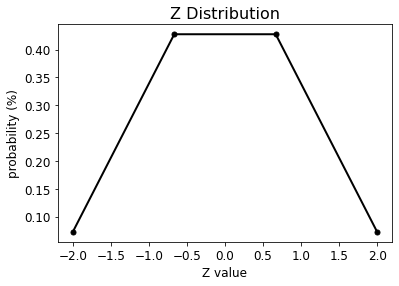

In [12]:
# Plot results for Z
plt.plot(z_values, p_z, "o-", linewidth=2, markersize=5, color=c_on)
plt.xlabel("Z value", size=label_size)
plt.ylabel("probability (%)", size=label_size)
plt.title("Z Distribution", size=title_size)
plt.xticks(size=label_size)
plt.yticks(size=label_size)
plt.show()

##### 4.1.3. Individual Default Probabilities

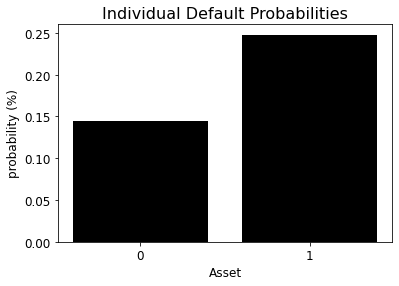

In [13]:
# Plot results for default probabilities
plt.bar(range(K), p_default, color=c_on)
plt.xlabel("Asset", size=label_size)
plt.ylabel("probability (%)", size=label_size)
plt.title("Individual Default Probabilities", size=title_size)
plt.xticks(range(K), size=label_size)
plt.yticks(size=label_size)
plt.show()

### 4.2. Expected Loss

To estimate the expected loss, we first apply a weighted sum operator to sum up individual losses to total loss:

$$ \mathcal{S}: |x_1, ..., x_K \rangle_K |0\rangle_{n_S} \mapsto |x_1, ..., x_K \rangle_K |\lambda_1x_1 + ... + \lambda_K x_K\rangle_{n_S} $$

The required number of qubits to represent the result is given by

$$ n_s = \lfloor \log_2( \lambda_1 + ... + \lambda_K ) \rfloor + 1 $$

Once we have the total loss distribution in a quantum register, we can use the techniques described [[4]](https://www.nature.com/articles/s41534-019-0130-6) to map a total loss $ L \in \{0, ..., 2^{n_s}-1\} $ to the amplitude of an objective qubit by an operator

$$ | L \rangle_{n_s}|0\rangle \mapsto
| L \rangle_{n_s} \left( \sqrt{1 - L/(2^{n_s}-1)}|0\rangle + \sqrt{L/(2^{n_s}-1)}|1\rangle \right) $$

Which allows to run amplitude estimation to evaluate the expected loss.


In [14]:
agg = WeightedAdder(n_z + K, [0] * n_z + lgd)
objective = LinearAmplitudeFunction(
    # Add Z qubits with weight/loss 0
    agg.num_sum_qubits,
    # Define linear objective function
    slope=[1],
    offset=[0],
    image=(0, sum(lgd)),
    rescaling_factor=0.25,
    breakpoints=[0],
    # This is the Max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2 ** agg.num_sum_qubits - 1),
)

Create the state preparation circuit:

In [15]:
# Define the registers for convenience and readability
qr_state = QuantumRegister(u.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_obj = QuantumRegister(1, "objective")
# Define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name="A")
# Load the random variable
state_preparation.append(u.to_gate(), qr_state)
# Aggregate
state_preparation.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])
# Linear objective function
state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])
# Uncompute aggregation
state_preparation.append(agg.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])
# Draw the circuit
state_preparation.draw()

┌───────┐┌────────┐      ┌───────────┐
  state_0: ┤0      ├┤0       ├──────┤0          ├
           │       ││        │      │           │
  state_1: ┤1      ├┤1       ├──────┤1          ├
           │  P(X) ││        │      │           │
  state_2: ┤2      ├┤2       ├──────┤2          ├
           │       ││        │      │           │
  state_3: ┤3      ├┤3       ├──────┤3          ├
           └───────┘│  adder │┌────┐│  adder_dg │
objective: ─────────┤        ├┤2   ├┤           ├
                    │        ││    ││           │
    sum_0: ─────────┤4       ├┤0 F ├┤4          ├
                    │        ││    ││           │
    sum_1: ─────────┤5       ├┤1   ├┤5          ├
                    │        │└────┘│           │
    carry: ─────────┤6       ├──────┤6          ├
                    └────────┘      └───────────┘

Before we use QAE to estimate the expected loss, we validate the quantum circuit representing the objective function by just simulating it directly and analyzing the probability of the objective qubit being in the $|1\rangle$ state, i.e., the value QAE will eventually approximate.

In [16]:
exe = execute(state_preparation, backend=Aer.get_backend("statevector_simulator"))
# Evaluate resulting statevector
value = 0
state = exe.result().get_statevector()
if not isinstance(state, np.ndarray):
    state = state.data
for i, a in enumerate(state):
    b = ("{0:0%sb}" % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1) :]
    prob = np.abs(a) ** 2
    if prob > 1e-6 and b[0] == "1":
        value += prob

# Print results
print("Exact Expected Loss:   %.4f" % expected_loss)
print("Exact Operator Value:  %.4f" % value)
print("Mapped Operator value: %.4f" % objective.post_processing(value))

Exact Expected Loss:   0.6409
Exact Operator Value:  0.3906
Mapped Operator value: 0.6639


Next we run IQAE to estimate the expected loss with a quadratic speed-up over classical Monte Carlo simulation.

In [17]:
qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = EstimationProblem(state_preparation=state_preparation, objective_qubits=[len(qr_state)], post_processing=objective.post_processing)
# Construct amplitude estimation, Set target precision and confidence level
ae = IterativeAmplitudeEstimation(0.01, alpha=0.05, quantum_instance=qi)
result = ae.estimate(problem)
conf_int = np.array(result.confidence_interval_processed)

# Print results
print("Exact value:    \t%.4f" % expected_loss)
print("Estimated value:\t%.4f" % result.estimation_processed)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact value:    	0.6409
Estimated value:	0.6263
Confidence interval: 	[0.5577, 0.6950]


<!-- ### 4.3. Cumulative Distribution Function

Instead of the expected loss (which could also be estimated efficiently using classical techniques) we now estimate the cumulative distribution function (CDF) of the loss. Classically, this either involves evaluating all the possible combinations of defaulting assets, or many classical samples in a Monte Carlo simulation. Algorithms based on QAE have the potential to significantly speed up this analysis in the future.

To estimate the CDF, i.e., the probability $\mathbb{P}[L \leq x]$, we again apply $\mathcal{S}$ to compute the total loss, and then apply a comparator that for a given value $x$ acts as

$$\begin{split} \mathcal{C}: |L\rangle_n|0> \mapsto
\begin{cases}
|L\rangle_n|1> & \text{if}\quad L \leq x \\
|L\rangle_n|0> & \text{if}\quad L > x
\end{cases}\end{split}$$

The resulting quantum state can be written as

$ \sum_{L = 0}^{x} \sqrt{p_{L}}|L\rangle_{n_s}|1\rangle +
\sum_{L = x+1}^{2^{n_s}-1} \sqrt{p_{L}}|L\rangle_{n_s}|0\rangle $

Where we directly assume the summed up loss values and corresponding probabilities instead of presenting the details of the uncertainty model.

The CDF $(x)$ equals the probability of measuring $|1\rangle$ in the objective qubit and QAE can be directly used to estimate it. -->

In [18]:
# # Set x value to estimate the CDF
# x_eval = 2
# comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
# comparator.draw()

In [19]:
def get_cdf_circuit(x_eval):
    # Define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, "state")
    qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
    qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
    qr_obj = QuantumRegister(1, "objective")
    # Define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name="A")
    # Load the random variable
    state_preparation.append(u, qr_state)
    # Aggregate
    state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:])
    # Comparator objective function
    comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
    state_preparation.append(comparator, qr_sum[:] + qr_obj[:] + qr_carry[:])
    # Uncompute aggregation
    state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])
    return state_preparation

# state_preparation = get_cdf_circuit(x_eval)

<!-- Again, we first use quantum simulation to validate the quantum circuit. -->

In [20]:
# exe = execute(state_preparation, backend=Aer.get_backend("statevector_simulator"))
# state_preparation.draw()

In [21]:
# # Evaluate resulting statevector
# var_prob = 0
# state = exe.result().get_statevector()
# if not isinstance(state, np.ndarray):
#     state = state.data
# for i, a in enumerate(state):
#     b = ("{0:0%sb}" % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1) :]
#     prob = np.abs(a) ** 2
#     if prob > 1e-6 and b[0] == "1":
#         var_prob += prob

# # Print results
# print("Operator CDF(%s)" % x_eval + " = %.4f" % var_prob)
# print("Exact    CDF(%s)" % x_eval + " = %.4f" % cdf[x_eval])

<!-- Next we run QAE to estimate the CDF for a given $x$. -->

In [22]:
# qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
# problem = EstimationProblem(state_preparation=state_preparation, objective_qubits=[len(qr_state)])
# # Construct amplitude estimation, set target precision and confidence level
# ae_cdf = IterativeAmplitudeEstimation(0.01, alpha=0.05, quantum_instance=qi)
# result_cdf = ae_cdf.estimate(problem)
# conf_int = np.array(result_cdf.confidence_interval)

# # Print results
# print("Exact value:    \t%.4f" % cdf[x_eval])
# print("Estimated value:\t%.4f" % result_cdf.estimation)
# print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

### 4.3. Value at Risk (VaR)

In the following we use a bisection search and IQAE to efficiently evaluate the Cumulative Distribution Function (CDF) to estimate the value at risk.

In [23]:
# Construct amplitude estimation
def run_ae_for_cdf(x_eval, epsilon=0.01, alpha=0.05, simulator="aer_simulator"):
    state_preparation = get_cdf_circuit(x_eval)
    qi = QuantumInstance(Aer.get_backend(simulator), shots=100)
    problem = EstimationProblem(state_preparation=state_preparation, objective_qubits=[len(qr_state)])
    ae_var = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
    result_var = ae_var.estimate(problem)
    return result_var.estimation

# Check whether low and high values are given and evaluated them otherwise
def bisection_search(objective, target_value, low_level, high_level, low_value=None, high_value=None):
    print("....................................................................")
    print(" 🕵️‍♂️ Start bisection search for target value: %.3f" % target_value)
    print("....................................................................")
    num_eval = 0
    if low_value is None:
        low_value = objective(low_level)
        num_eval += 1
    if high_value is None:
        high_value = objective(high_level)
        num_eval += 1
    # Check if low_value already satisfies the condition
    if low_value > target_value:
        return {"level": low_level, "value": low_value, "num_eval": num_eval, "comment": "returned low value"}
    elif low_value == target_value:
        return {"level": low_level, "value": low_value, "num_eval": num_eval, "comment": "success"}
    # Check if high_value is above target
    if high_value < target_value:
        return {"level": high_level, "value": high_value, "num_eval": num_eval, "comment": "returned low value"}
    elif high_value == target_value:
        return {"level": high_level, "value": high_value, "num_eval": num_eval, "comment": "success"}
    # Perform bisection search until
    print("low_level    low_value    level    value    high_level    high_value")
    print("....................................................................")
    while high_level - low_level > 1:
        level = int(np.round((high_level + low_level) / 2.0))
        num_eval += 1
        value = objective(level)
        print(
            "%2d           %.3f        %2d       %.3f    %2d            %.3f"
            % (low_level, low_value, level, value, high_level, high_value)
        )
        if value >= target_value:
            high_level = level
            high_value = value
        else:
            low_level = level
            low_value = value
    print("....................................................................")
    print(" 🔚 Finished bisection search ")
    print("....................................................................")
    # Return high value after bisection search
    return {"level": high_level, "value": high_value, "num_eval": num_eval, "comment": "success"}

# Run bisection search to determine VaR
objective = lambda x: run_ae_for_cdf(x)
bisection_result = bisection_search(objective, 1 - alpha, min(losses) - 1, max(losses), low_value=0, high_value=1)
var = bisection_result["level"]

# Print results
print("\n\n")
print("Estimated Value at Risk: %2d" % var)
print("Exact Value at Risk:     %2d" % exact_var)
print("Estimated Probability:    %.3f" % bisection_result["value"])
print("Exact Probability:        %.3f" % cdf[exact_var])

....................................................................
 🕵️‍♂️ Start bisection search for target value: 0.950
....................................................................
low_level    low_value    level    value    high_level    high_value
....................................................................
-1           0.000         1       0.752     3            1.000
 1           0.752         2       0.959     3            1.000
....................................................................
 🔚 Finished bisection search 
....................................................................



Estimated Value at Risk:  2
Exact Value at Risk:      2
Estimated Probability:    0.959
Exact Probability:        0.959


### 4.4 Conditional Value at Risk (CVaR)

Last, we compute the CVaR, the expected value of the loss conditional to it being larger than or equal to the VaR. To do so, we evaluate a piecewise linear objective function $f(L)$, dependent on the total loss $L$, that is given by:

$$\begin{split}f(L) = \begin{cases}
0 & \text{if}\quad L \leq VaR \\
L & \text{if}\quad L > VaR.
\end{cases}\end{split}$$

To normalize, we have to divide the resulting expected value by the VaR-probability, i.e. $\mathbb{P}[L \leq VaR]$.

In [24]:
cvar_objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    [0, 1],
    # Subtract VaR and add it later to the estimate
    [0, 0],
    domain=(0, 2 ** agg.num_sum_qubits - 1),
    image=(0, 3 - var),
    rescaling_factor=0.25,
    breakpoints=[0, var],
)
cvar_objective.draw()

┌────┐
q369_0: ┤0   ├
        │    │
q369_1: ┤1   ├
        │    │
  q370: ┤2 F ├
        │    │
  a2_0: ┤3   ├
        │    │
  a2_1: ┤4   ├
        └────┘

In [25]:
# Define the registers for convenience and readability
qr_state = QuantumRegister(u.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_obj = QuantumRegister(1, "objective")
qr_work = QuantumRegister(cvar_objective.num_ancillas - len(qr_carry), "work")
# Define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, qr_work, name="A")
# Load the random variable
state_preparation.append(u, qr_state)
# Aggregate
state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:])
# Linear objective function
state_preparation.append(cvar_objective, qr_sum[:] + qr_obj[:] + qr_carry[:] + qr_work[:])
# Uncompute aggregation
state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

Again, we first use quantum simulation to validate the quantum circuit.

In [26]:
exe = execute(state_preparation, backend=Aer.get_backend("statevector_simulator"))
# Evaluate resulting statevector
value = 0
state = exe.result().get_statevector()
if not isinstance(state, np.ndarray):
    state = state.data
for i, a in enumerate(state):
    b = ("{0:0%sb}" % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1) :]
    prob = np.abs(a) ** 2
    if prob > 1e-6 and b[0] == "1":
        value += prob

# Normalize and add VaR to estimate
value = cvar_objective.post_processing(value)
d = 1.0 - bisection_result["value"]
v = value / d if d != 0 else 0
normalized_value = v + var

# Print results
print("Estimated CVaR: %.4f" % normalized_value)
print("Exact CVaR:     %.4f" % exact_cvar)

Estimated CVaR: 3.2834
Exact CVaR:     3.0000


Next we run IQAE to estimate the CVaR.

In [27]:
qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=cvar_objective.post_processing,
)
# Construct amplitude estimation, set target precision and confidence level
ae_cvar = IterativeAmplitudeEstimation(0.01, alpha=0.05, quantum_instance=qi)
result_cvar = ae_cvar.estimate(problem)
d = 1.0 - bisection_result["value"]
v = result_cvar.estimation_processed / d if d != 0 else 0

# Print results
print("Exact CVaR:    \t%.4f" % exact_cvar)
print("Estimated CVaR:\t%.4f" % (v + var))

Exact CVaR:    	3.0000
Estimated CVaR:	3.2491


## 5. Conclusions

By now, most people have heard that quantum computing is a revolutionary technology that leverages the bizarre characteristics of quantum mechanics to solve certain problems faster than regular computers can. Those problems range from the worlds of mathematics to retail business, and physics to finance. But, as we have seen recently, quantum computers (QC) are exceedingly difficult to engineer, build and program. As a result, they are crippled by errors in the form of noise, faults and loss of quantum coherence.

While classical computers (CC) are also affected by various sources of errors, these errors can be corrected with a modest amount of extra storage and logic. Quantum error­ correction schemes do exist but consume such a large number of qubits that relatively few qubits remain for actual computation. So when only a couple of qubits are required it could be feasible, but when the number required increases the computing is not viable. This reduces the size of the computing task to a tiny fraction of what could run on defect-­free hardware.

So, all in all, the application of this quantum algorithm (or quantum computing in general) is not feasible due to the noise and the quantity of qubits required.

## 6. References

- [1] Purpose of Credit Risk Analysis ([corporatefinanceinstitute.com](https://corporatefinanceinstitute.com/resources/knowledge/credit/purpose-of-credit-risk-analysis/))
- [2] How Quantum Computing Could Change Financial Services ([mckinsey.com](https://www.mckinsey.com/industries/financial-services/our-insights/how-quantum-computing-could-change-financial-services))
- [3] Credit Risk Analysis ([qiskit](https://qiskit.org/documentation/finance/tutorials/09_credit_risk_analysis.html))
- [4] Quantum Risk Analysis. Stefan Woerner, Daniel J. Egger et al. (2019) ([nature](https://www.nature.com/articles/s41534-019-0130-6))
- [5] Credit Risk Analysis using Quantum Computers. Egger et al. (2019) ([arxiv.org](https://arxiv.org/abs/1907.03044))
- [6] Quantum Amplitude Amplification and Estimation. Gilles Brassard et al. (2000) ([arxiv.org](http://arxiv.org/abs/quant-ph/0005055))
- [7] Three stages of the 3-qubit Grover search algorithm ([phys.org](https://scx2.b-cdn.net/gfx/news/2018/groversearch.jpg))
- [8] Iterative quantum amplitude estimation ([nature](https://www.nature.com/articles/s41534-021-00379-1))